<a href="https://colab.research.google.com/github/siruku6/fx_notebooks/blob/master/220623_ohlc_chartizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. モジュールの準備

In [1]:
!pip install -q mplfinance

     |████████████████████████████████| 70 kB 4.7 MB/s 


In [2]:
import os

from google.colab import files
import matplotlib
import matplotlib.pyplot as plt
import mplfinance.original_flavor as original_mpf
import mplfinance as mpf
import numpy as np
import pandas as pd
from tqdm import tqdm

# matplotlib.use('Agg')


# 2. データ読み込みと確認

In [3]:
# Upload `220620_GBP_JPY_H1.csv`
uploaded = files.upload()

Saving 220620_GBP_JPY_H1.csv to 220620_GBP_JPY_H1.csv


In [11]:
df_candles: pd.DataFrame = pd.read_csv('/content/220620_GBP_JPY_H1.csv', parse_dates=['time'])
df_candles.head(3)

,low,open,high,close,time
0,156.053,156.087,156.193,156.136,2021-10-31 21:00:00
1,156.088,156.117,156.240,156.226,2021-10-31 22:00:00
2,156.118,156.224,156.334,156.311,2021-10-31 23:00:00


In [12]:
print(df_candles.dtypes)
df_candles.info()

low             float64
open            float64
high            float64
close           float64
time     datetime64[ns]
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3863 entries, 0 to 3862
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   low     3863 non-null   float64       
 1   open    3863 non-null   float64       
 2   high    3863 non-null   float64       
 3   close   3863 non-null   float64       
 4   time    3863 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 151.0 KB


# 3. 学習データ作り

## 3-1. 正解ラベル作り

正解ラベル（目的変数）を作る

https://github.com/rosdyana/Going-Deeper-with-Convolutional-Neural-Network-for-Stock-Market-Prediction/blob/a59152477f46e673a244c0f9b5340c272504024a/preproccess_binclass.py#L105

正解ラベルの列 `target` を追加する

- target: int (-1, 0, 1のいずれか)  
画像内の最終足の`close`の値（終値）よりも、5本先の `close`の値が、

|No|内容|Label|
|:-|:---|----:|
|1|`0.3`以上上回っている| 1|
|2|`0.3`以上下回っている| 2|
|3|どちらでもない| 0|


In [13]:
# 5本先の足のclose値を列に追加
df_tmp_candles = df_candles.copy()
df_tmp_candles.loc[:, 'close:lag+5'] = df_tmp_candles['close'].shift(-5)
df_tmp_candles.head(8)

,low,open,high,close,time,close:lag+5
0,156.053,156.087,156.193,156.136,2021-10-31 21:00:00,156.134
1,156.088,156.117,156.240,156.226,2021-10-31 22:00:00,156.225
2,156.118,156.224,156.334,156.311,2021-10-31 23:00:00,156.238
3,155.922,156.314,156.338,155.992,2021-11-01 00:00:00,156.351
4,155.952,155.990,156.204,156.185,2021-11-01 01:00:00,156.274
5,156.042,156.183,156.183,156.134,2021-11-01 02:00:00,156.197
6,156.129,156.136,156.298,156.225,2021-11-01 03:00:00,156.016
7,156.204,156.222,156.322,156.238,2021-11-01 04:00:00,156.024


In [14]:
# 実装中
# https://note.nkmk.me/python-pandas-where-mask/
series_gap_between_5_candles = (df_tmp_candles['close:lag+5'] - df_tmp_candles['close'])

threthold: float = 0.3
up = np.where(series_gap_between_5_candles > threthold, True, False)
down = np.where(series_gap_between_5_candles < -threthold, True, False)

df_tmp_candles.loc[up, 'class'] = 1
df_tmp_candles.loc[down, 'class'] = 2
df_tmp_candles.loc[~(up | down), 'class'] = 0
df_tmp_candles = df_tmp_candles.astype({'class': int})
df_tmp_candles.head(20)

,low,open,high,close,time,close:lag+5,class
0,156.053,156.087,156.193,156.136,2021-10-31 21:00:00,156.134,0
1,156.088,156.117,156.240,156.226,2021-10-31 22:00:00,156.225,0
2,156.118,156.224,156.334,156.311,2021-10-31 23:00:00,156.238,0
3,155.922,156.314,156.338,155.992,2021-11-01 00:00:00,156.351,1
4,155.952,155.990,156.204,156.185,2021-11-01 01:00:00,156.274,0
5,156.042,156.183,156.183,156.134,2021-11-01 02:00:00,156.197,0
6,156.129,156.136,156.298,156.225,2021-11-01 03:00:00,156.016,0
7,156.204,156.222,156.322,156.238,2021-11-01 04:00:00,156.024,0
8,156.236,156.240,156.448,156.351,2021-11-01 05:00:00,155.991,2
9,156.210,156.353,156.389,156.274,2021-11-01 06:00:00,156.235,0


## 3-2. 画像の描画準備

In [15]:
# mplfinance使うときは、indexがDatetimeIndex型でなければならない
df_candles = df_candles.set_index('time')

## 3-3. お試し描画

/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:46: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


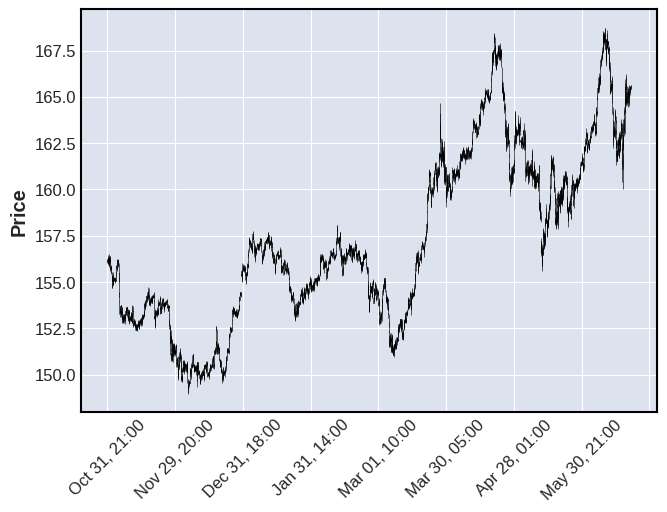

In [16]:
# 素のまま描画
mpf.plot(df_candles, type='candle')

## 3-4. 実践的な描画

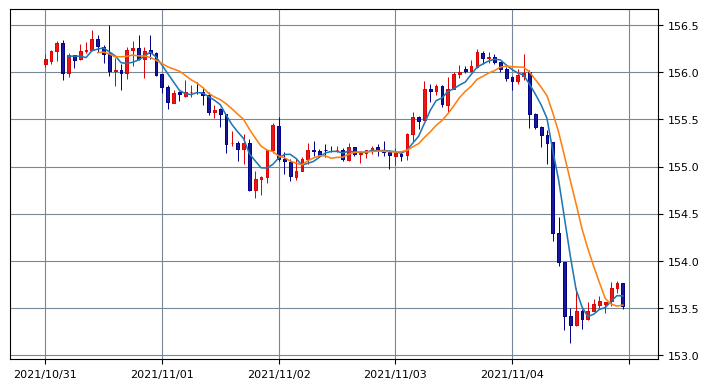

In [ ]:
# 表示する量を削ってみる
df = df_candles[0:100]

# 描画方法の設定
marketcolors = mpf.make_marketcolors(
    up="#DF0101", down="#00008b", edge="inherit", wick="inherit"
)
chart_style = mpf.make_mpf_style(
    marketcolors=marketcolors,
    gridcolor="#778899",
    y_on_right=True,
    rc={"xtick.labelsize":8, "ytick.labelsize":8}
)

# 描画開始
mpf.plot(
    # 表示するもの
    df,           # ローソク足
    mav=(5, 10),  # 移動平均線 (moving average)

    # 表示方法
    type='candle', datetime_format='%Y/%m/%d',
    figsize=(9,5), style=chart_style, width_adjuster_version='v1',
    xrotation=False, ylabel='', ylabel_lower=''
)

# 参考にした記事
# https://chimesness.com/post-397/
# https://chimesness.com/post-448/

## 3-5. 学習用画像の描画（ボツ）

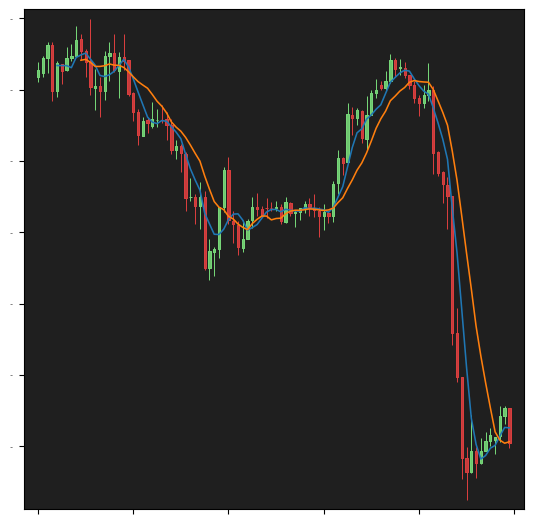

In [17]:
# 表示する量を削ってみる
df = df_candles[0:100]

# 描画方法の設定
marketcolors = mpf.make_marketcolors(
    up='#77d879', down='#db3f3f',
    edge="inherit", wick="inherit"
)
chart_style = mpf.make_mpf_style(
    marketcolors=marketcolors,
    gridstyle='None',
    facecolor='#1f1f1f',
    rc={
        "xtick.labelsize": 0, "ytick.labelsize": 0,
        # 'axes.yticklabels': False, 'axes.xticklabels': False,
        'axes.xmargin': 0.02,
        'axes.ymargin': 0.02,
    }
)


# 描画開始
mpf.plot(
    # 表示するもの
    df,           # ローソク足
    mav=(5, 10),  # 移動平均線 (moving average)

    # 表示方法
    type='candle', datetime_format='',
    figsize=(5, 5), style=chart_style, width_adjuster_version='v1',
    xrotation=False, ylabel='', ylabel_lower='', scale_padding={'left': 0, 'top': 0, 'right': 0, 'bottom': 0}
)

# 参考にした記事
# https://chimesness.com/post-397/
# https://chimesness.com/post-448/

## 3-6. 学習用画像（気を取り直して）

新mplfinanceでは、4方の余白を削るのが難しそうなので、original_fravourに変更

In [18]:
def init_figure() -> plt.Figure:
    """
    初期設定
    """
    # 余白
    plt.rcParams['axes.xmargin'] = 0.05
    plt.rcParams['axes.ymargin'] = 0.05
    # 画像サイズ、解像度(値が大きいと画像データが大きくなり、処理時間が増える)
    fig: plt.Figure = plt.figure(figsize=(3, 3), dpi=64)
    # 背景色
    fig.patch.set_facecolor('black')
    return fig


def eliminate_unnecessities(ax1: plt.Axes) -> None:
    """
    余計なものを全部消す
    （文字やグリッド線、余白など）
    """
    ax1.grid(False)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.axis('off')


def draw_candles(ax1: plt.Axes, df: pd.DataFrame) -> None:
    """
    ローソク足を描画
    """
    original_mpf.candlestick2_ohlc(
        ax1,
        df['open'], df['high'], df['low'], df['close'],
        width=0.5,  # ローソク足1本の太さ
        colorup='#77d879', colordown='#db3f3f'  # 色
    )


def save_chart(fig: plt.Figure, dir_name: str, index: int) -> None:
    os.makedirs(dir_name, exist_ok=True)

    filename: str = f'{dir_name}/sample_{index}.png'
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.05, top=1.0)
    fig.savefig(
        filename, pad_inches=0,
        facecolor=fig.get_facecolor(), transparent=False
    )


def make_image(df: pd.DataFrame, i: int) -> None:
    # チャート画像の入れ物（インスタンス）を初期化
    fig: plt.Figure = init_figure()

    # イメージ描画先を1枚作成
    ax1: plt.Axes = fig.add_subplot(1, 1, 1)

    # 文字やグリッド線、余白などを消す
    eliminate_unnecessities(ax1)

    # ローソク足を描画
    draw_candles(ax1, df)

    # 画像をpngファイルとして保存
    dir_name = 'chart_pngs'
    # filename: str = 'dataset/{}_{}/{}/{}/{}-{}.png'.format(
    #     seq_len, dimension, symbol, dataset_type, fname[11:-4], i
    # )
    save_chart(fig, dir_name, i)

    plt.close(fig)


# 参考資料
# - https://github.com/rosdyana/Going-Deeper-with-Convolutional-Neural-Network-for-Stock-Market-Prediction/blob/a59152477f46e673a244c0f9b5340c272504024a/preproccess_binclass.py#L145-L200
# - https://stackoverflow.com/questions/4804005/matplotlib-figure-facecolor-background-color


In [21]:
period_in_one_image: int = 30
num_images: int = len(df_candles) - period_in_one_image
# num_images: int = 50 - period_in_one_image

for i in tqdm(range(num_images)):
    df: pd.DataFrame = df_candles[i : i + period_in_one_image]
    make_image(df, i)


100%|██████████| 3833/3833 [03:22<00:00, 18.90it/s]


In [ ]:
! zip chart_pngs.zip /content/chart_pngs/*

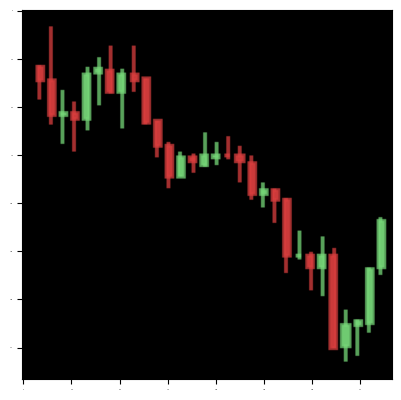

In [20]:
img = plt.imread('./chart_pngs/sample_10.png')
plt.imshow(img)

## 3-7. 学習用画像に移動平均線とボリンジャーバンドを追加

In [25]:
# 未対応

# X. リサンプリング

以下のように、日足（1時間で1本だったローソク足を1日1本にまとめたもの）にすれば、データが欠損している日を容易に特定できる

見てみると、土日祝日は基本的に欠損している
これは為替市場がお休みだからである

In [ ]:
pd.set_option('display.max_rows', 400)
df_candles.resample('D').agg(
    {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last'
    }
)

# 参考にした記事
# https://qiita.com/u1and0/items/8e7bcaaf3668ed2afee1

In [ ]:
# いちいち何百列もデータフレームが表示されると邪魔なので、設定を元に戻しておく
pd.set_option('display.max_rows', 10)

# X. 発展資料

- 3つ目以降のグラフを表示させる方法  
http://hachisue.blog65.fc2.com/blog-entry-467.html